# 시계열 예측

- 시계열 값의 미래 예측 (time series forecasting)
 - 수요예측, 매출예측, 생산/물류/재고 예측, 리스크/장애/이상 예측 등
 
## 접근법
- (1) 자신의 과거 값만 사용하여 미래 값을 예측하는 (y-y 모델)
  - 선형예측, ARIMA, Prophet 등 수리 모델 기반의 단변수 예측 모델 사용
  - 랜덤한 성분은 예측이 안된다 (트렌드, 주기성 만 예측 가능)
- (2) 다양한 외부 특성들을 사용하여 예측하는 (X-y 모델)
  - y에 영향을 주는 다양한 환경 변수들을 입력 특성 X에 포함한다
  - X에 y의 과거 값들도 포함시킬 수 있다 (위의 1을 포함하는 셈!)
  - 입력 X에 변형된 특성을 추가할 수 있다 (이동 평균, 이동 분산 등)
  - 카테고리 변수들이 많으면 X-y 모델이 잘 동작한다 (선형계열 모델은 카테고리 변수를 표현하는데 한계가 있다)
  - 임의의 머신러닝 모델을 사용할 수 있다
- (3) 샘플(행) 단위로 예측하는 것이 아니라 입력신호의 누적 효과(여러 행)를 반영하는 경우
  - 신경망 모델, LSTM을 사용한다
  - 좋은 성능을 얻으려면 학습 데이터가 충분히 많아야 한다

# import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import matplotlib

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error,r2_score               

## 단변수 시계열 예측

<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-09%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%2011.16.26.png?raw=1" width=450 align='left'>

- 선형 회귀 (linear regression) 모델: 자신의 과거 샘플의 가중합으로 미래를 예측하는 모델


 > $\hat{y_{n}} = b +a_{1}y_{n-1} + a_{2}y_{n-2} + a_{3}y_{n-3} + ...$
 
 - ARIMA 모델: 선형 모델을 개선하여, 계절성, 트렌드, 시변성 등을 반영한 모델
  - 결측치가 없어야 한다
 - 단변수 시계열 예측 도구로 Prophet이 편리하다 (결측치 자동처리, 이벤트 반영 등)

## 날씨 데이터

In [3]:
weather = pd.read_csv('https://raw.githubusercontent.com/StillWork/data/master/new_weather.csv')
print(weather.shape)
weather[:3]

(4018, 4)


,연월일,기온,품질,균질
0,2006/1/1,3.6,8,1
1,2006/1/2,4.0,8,1
2,2006/1/3,3.7,8,1


- 단변수 시계열
 - 날짜 정보를 사용하지 않고 일정 시간간격의 숫자 데이터만 사용하는 주어지는 경우

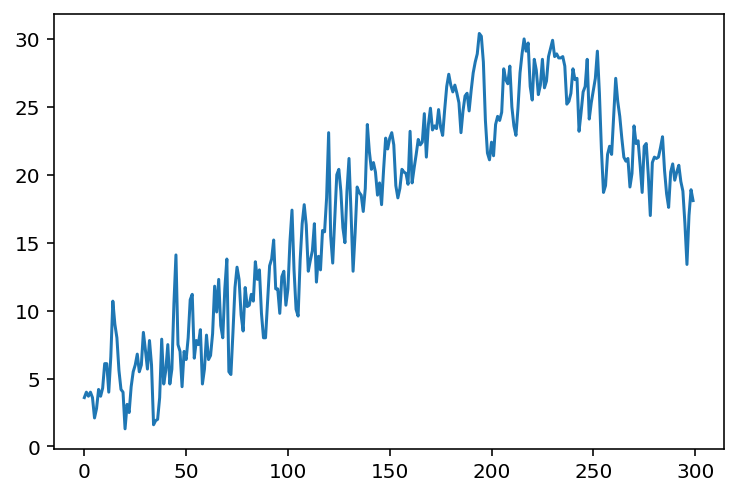

In [4]:
y = weather["기온"].values
plt.plot(y[:300])

## 훈련, 검증 데이터 나누기
- 시계열 데이터는 순서를 유지해야 의미가 있으므로 랜덤하게 섞으면 안된다
- 보통 앞 시간의 데이터로 훈련을 시키고 뒷 부분의 데이터로 검증한다
- train_test_split()에서 shuffle=False로 설정해야 한다

In [5]:
# 앞부분 75%를 훈련 데이터로, 나머지를 검증 데이터로 나누며 순서를 유지한다
train_data, test_data = train_test_split(y, shuffle=False)
len(y), len(train_data), len(test_data)

(4018, 3013, 1005)

## walk forward 예측
- 내일이 되면 내일 기온을 알 수 있으므로 모레 기온을 예측하는데 내일 데이터를 사용할 수 있다
- 이렇게 미래로 하나씩 이동하면서 데이터를 이용하는 예측을 walk forward 예측이라고 한다
- 시계열 데이터를 테이블 구조로 만들기
 - 시계열 예측에 머신러닝 모델을 쉽게 적용하기 위해서 비정형인 시계열 데이터를 정형 데이터인 테이블 구조로 만들어야 한다
 - 아래는 5개의 시계열 데이터를 보고 6번째 값을 예측하는 경우이며 walk forward 예측을 위한 테이블을 오른 쪽에 나타냈다


<img src="https://raw.githubusercontent.com/data-labs/image/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-08%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%203.44.24.png?raw=1" width=600 aligh='left'>

## split_seq()
- 시계열 데이터를 테이블 구조로  표현하는 작업을 수행
 - sequence는 입력 시계열 데이터
 - n_steps는 예측에 사용할 한 행(샘플)의 크기 (위 그림에서 5임)
  - 이를 윈도우 크기라고도 한다

In [7]:
def split_seq(sequence, n_steps):
    
    # 테이블 데이터를 담을 빈 리스트 준비
    x, y = [], []
    for i in range(len(sequence)):
        if i > len(sequence) - (n_steps + 1) : break
        x.append(sequence[i:i+n_steps])
        y.append(sequence[i+n_steps])

    # 리스트를 어레이로 바꾸어서 리턴한다 (바로 연산에 사용할 수 있도록)
    return np.array(x), np.array(y)

In [8]:
# 예: 과거 5개의 샘플을 보고 다음 값을 예측하기 위한 훈련데이터 X, y 생성
sequence = [1,2,3,4,5,6,7,8,9,10,11,12,13]
x_train, y_train = split_seq(sequence, 5)
x_train, y_train

(array([[ 1,  2,  3,  4,  5],
        [ 2,  3,  4,  5,  6],
        [ 3,  4,  5,  6,  7],
        [ 4,  5,  6,  7,  8],
        [ 5,  6,  7,  8,  9],
        [ 6,  7,  8,  9, 10],
        [ 7,  8,  9, 10, 11],
        [ 8,  9, 10, 11, 12]]),
 array([ 6,  7,  8,  9, 10, 11, 12, 13]))

## (실습) n_steps 변경
- n_steps 가 7일 경우의 split_seq()를 수행해보시오

In [9]:
# (풀이)



# 선형 예측 모델
- Linear Prediction
- 자신의 과거 샘플의 가중합으로 미래값을 예측하는 모델
- 선형 회귀 (linear regression) 모델을 사용하면 된다

 > $\hat{y_{n}} = b +a_{1}y_{n-1} + a_{2}y_{n-2} + a_{3}y_{n-3} + ...$
 


## 최적의 n_steps 찾기

- 선형 예측 모델에서 과거 몇 개를 예측에 사용하면 성능이 가장 좋은지 최적 값 찾기
- 과거 1 ~180일의 데이터를 사용해본다

In [20]:
N = 180
model = LinearRegression()

# 실험 결과를 담을 리스트
result = []

for n_steps in range(1,N+1): 
    x_train, y_train = split_seq(train_data, n_steps)
    x_test, y_test = split_seq(test_data, n_steps)
    model.fit(x_train, y_train) 
    result.append((n_steps, model.score(x_test, y_test)))

In [23]:
result[:3]

[(1, 0.9278711483333497), (2, 0.9284242771093589), (3, 0.9318384895047028)]

<AxesSubplot:xlabel='steps'>

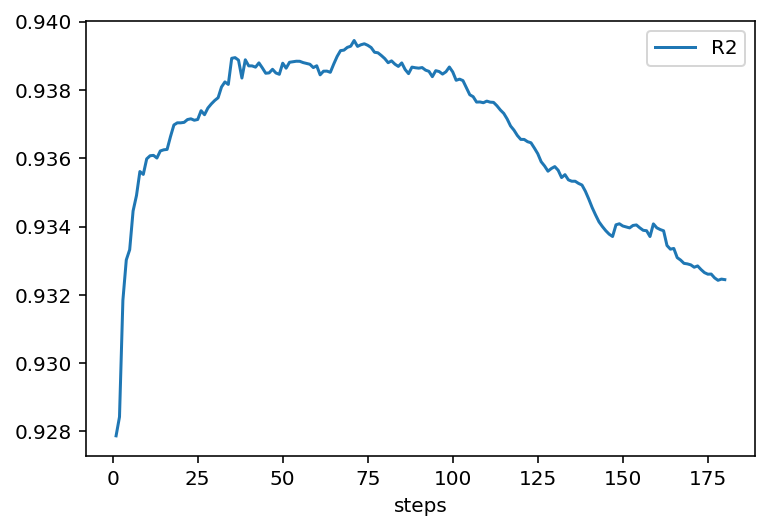

In [32]:
# 실험 결과 보기

df = pd.DataFrame(result, columns=['steps', 'R2']).set_index('steps')
df.plot()

In [33]:
# 최대 성능을 얻는 n_steps와 최대 성능 찾기

df.idxmax(), df.max()

(R2    71
 dtype: int64,
 R2    0.939447
 dtype: float64)

In [34]:
# 최적 n_steps를 적용한 모델

n_steps = 71

x_train, y_train = split_seq(train_data, n_steps)
x_test, y_test = split_seq(test_data, n_steps)
model = LinearRegression()
model.fit(x_train, y_train) 
model.score(x_test, y_test).round(4)

0.9394

## 모델 성능 평가
- 회귀 모델의 성능을 평가하는 척도로 기본적으로 R-Squared를 사용하며 MAE, RMSE 등을 참고로 본다
 - MAE: mean absolute error  
 - MSE: mean squared error    
 - RMSE: root MSE  

$MAE = $$1\over{N}$$ \sum |y_{i} - \hat{y}|$

$MSE = $$1\over{N}$$ \sum (y_{i} - \hat{y})^{2}$

$RMSE = \sqrt{MSE}$

$R^{2} = 1$-$\sum(y_{i}-\hat{y})^{2}\over{\sum(y_{i}-\bar{y})^{2}}$ $= 1$-$MSE\over{Variance}$  
 >  $y$ :  실제값  
 >  $\hat{y}$ :  예측치  
 >  $\bar{y}$ :  평균치
 
- R-Squared
  - 회귀 성능의 기본적인 평가 지표
  - MSE를 분산으로 정규화한 값을 사용한다
  - R-sqaured 값은 1에 가까울수록 완벽한 예측을 수행한 것이고, 0 근처이면 오차 평균치가 표준편차 정도인 경우이다

In [11]:
def show_reg_result(y_test,y_pred):
    print("Max Error: ", 
      round(np.abs(y_test - y_pred).max(),3))
    print("Mean Absolute Error: ", 
      round(np.abs(y_test-y_pred).mean(),3))
    print("Root Mean Squared Error: ", 
      mean_squared_error(y_test,y_pred, squared=False).round(3))
    print("R-Squared: ", 
      r2_score(y_test, y_pred).round(3))

In [12]:
def plot_reg_result(y_test, y_pred, N=50):
    y_t=y_test.ravel()
    y_p=y_pred.ravel()
    plt.plot(y_t[:N], 'r.-', label='y_test')
    plt.plot(y_p[:N], 'b.--', label='y_pred')
    plt.legend()
    plt.show()
    plt.title("Residue Plot")
    plt.scatter(y_t, y_t - y_p, s=5)

- 회귀 예측 성능 보기

In [35]:
y_pred = model.predict(x_test)
show_reg_result(y_test, y_pred)

Max Error:  7.497
Mean Absolute Error:  1.492
Root Mean Squared Error:  1.912
R-Squared:  0.939


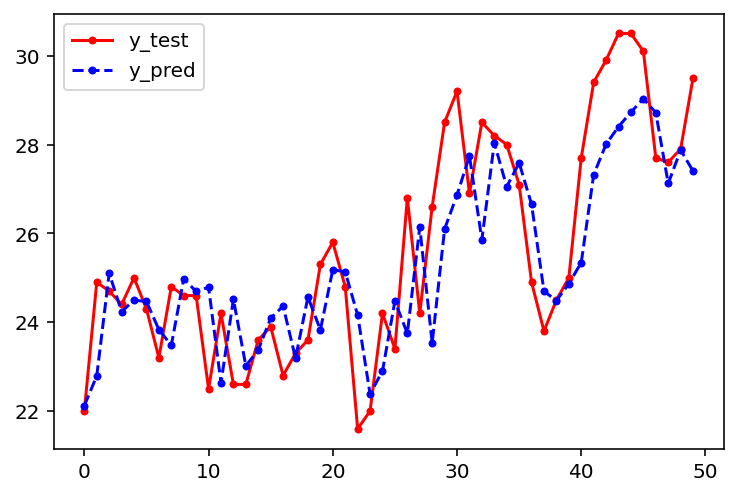

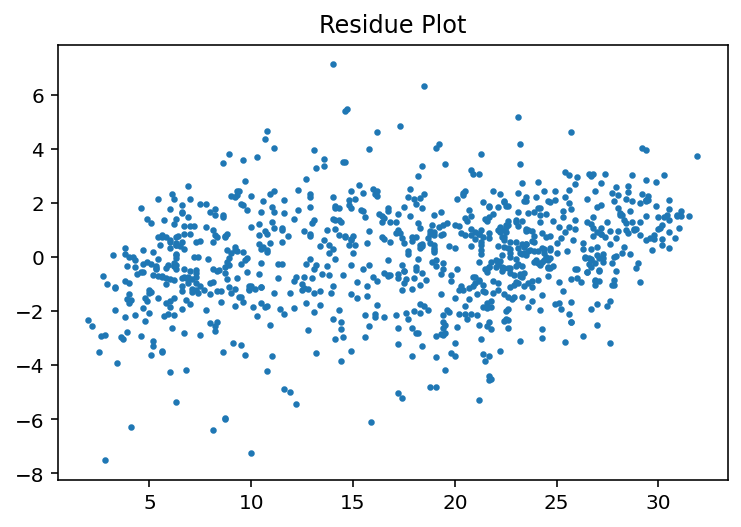

In [36]:
plot_reg_result(y_test, y_pred)

# 베이스라인 모델
- 간단히 만들 수 있는 모델로 나이브 모델이라고도 한다
- 최소한 이것보다는 성능이 개선된 모델을 만들어야 한다
- 종류
 - persistent 모델: 직전의 샘플 값으로 다음 값을 예측
 - 이동 평균 모델: 직전의 N개 샘플의 평균으로 예측 (최근 값의 비중을 크게 반영하는 지수형 가중 평균을 사용하기도 한다, ema:exponential moving average)
 - 직전 값들이 아니라 주기적인 일정 간격으로 샘플을 취하기도 한다

In [37]:
## persistent 모델

# 위에서 n_steps = 1 일 때의 성능
result[:3]

[(1, 0.9278711483333497), (2, 0.9284242771093589), (3, 0.9318384895047028)]

# 에너지 사용 예측

## 데이터

- 가정의 에너지 사용 예측

In [38]:
power = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/energy_3years.csv",
                 parse_dates=['timestamp'])
power.set_index("timestamp", inplace=True)

print(power.shape)
power[:3]

(26304, 2)


,load,temp
timestamp,,
2012-01-01 00:00:00,2698.0,32.000000
2012-01-01 01:00:00,2558.0,32.666667
2012-01-01 02:00:00,2444.0,30.000000


<AxesSubplot:xlabel='timestamp'>

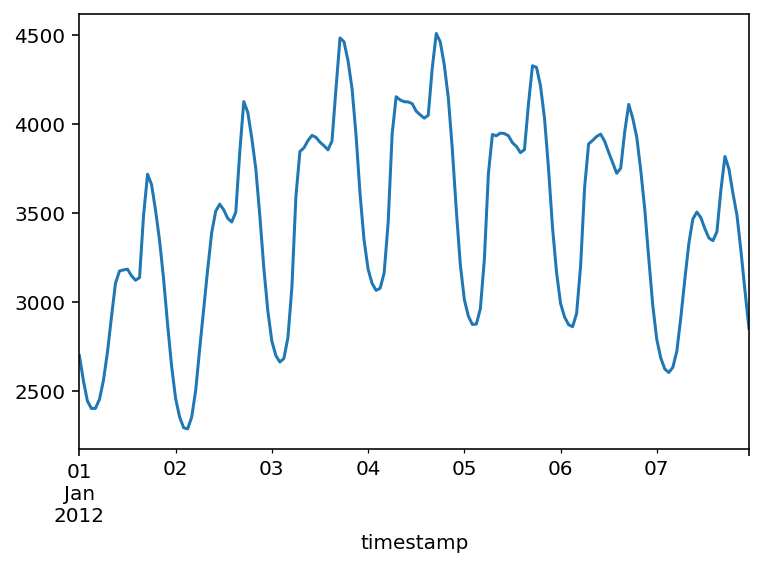

In [39]:
# 1주일간의 데이터 보기
power.load[:24*7].plot()

- 시간 단위 데이터를 일 단위 데이터로 다운 샘플링 하는 방법
- 하루의 전력 사용량 합계를 사용하겠다

In [40]:
df_down = power.resample('D').sum()
print(df_down.shape)
df_down[:3]

(1096, 2)


,load,temp
timestamp,,
2012-01-01,71562.0,906.333333
2012-01-02,76841.0,897.666667
2012-01-03,87887.0,418.333333


- 기온은 합이 아니라 평균을 사용하겠다.

In [41]:
df_down['temp'] = power.temp.resample('D').mean()
df_down[:5]

,load,temp
timestamp,,
2012-01-01,71562.0,37.763889
2012-01-02,76841.0,37.402778
2012-01-03,87887.0,17.430556
2012-01-04,92168.0,13.111111
2012-01-05,88096.0,24.875000


## 단변수 시계열 예측

- 전력 사용량(load)만 사용하는 경우

- 데이터 나누기

In [44]:
y = df_down.load
train_data, test_data = train_test_split(y, shuffle=False)
len(y), len(train_data), len(test_data)

(1096, 822, 274)

### 선형 예측 모델

In [47]:
N = 120
model = LinearRegression()
result = []

for n_steps in range(1,N+1): 
    x_train, y_train = split_seq(train_data, n_steps)
    x_test, y_test = split_seq(test_data, n_steps)
    model.fit(x_train, y_train) 
    result.append((n_steps, model.score(x_test, y_test)))

<AxesSubplot:xlabel='steps'>

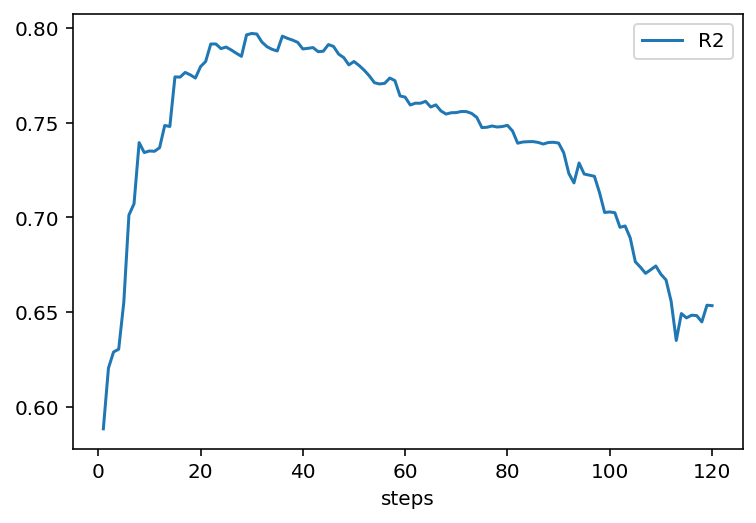

In [48]:
# 실험 결과 보기

df = pd.DataFrame(result, columns=['steps', 'R2']).set_index('steps')
df.plot()

In [49]:
# 최대 성능을 얻는 n_steps 찾기
df.idxmax(), df.max()

(R2    30
 dtype: int64,
 R2    0.796969
 dtype: float64)

- 최적의 윈도우 선택

In [50]:
n_steps = 30

x_train, y_train = split_seq(train_data, n_steps)
x_test, y_test = split_seq(test_data, n_steps)
model.fit(x_train, y_train) 
y_pred = model.predict(x_test)
show_reg_result(y_test, y_pred)

Max Error:  14205.837
Mean Absolute Error:  2220.282
Root Mean Squared Error:  3031.463
R-Squared:  0.797


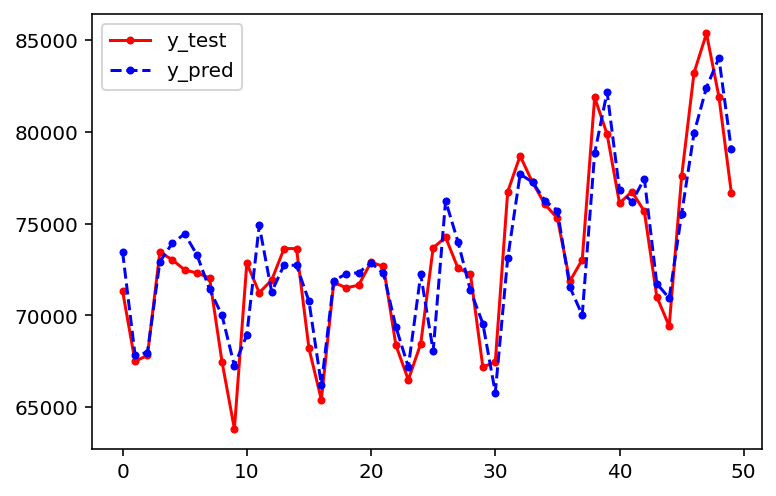

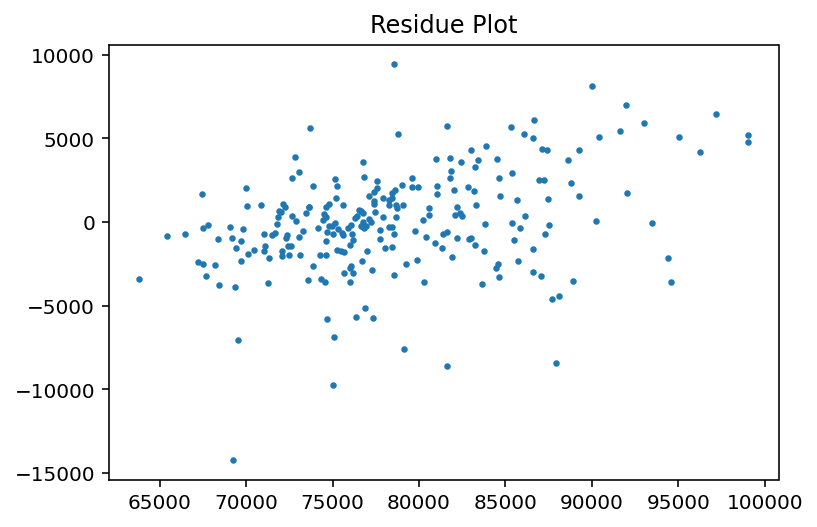

In [51]:
plot_reg_result(y_test, y_pred)

- 모델, 데이터, 윈도우 크기를 주면 시계열 분석을 수행하는 함수 정의

### LGBMRegressor 모델을 사용하는 경우

- 랜덤 포레스트 모델을 사용하는 경우

In [53]:
from sklearn.ensemble import RandomForestRegressor
lgbm_r = LGBMRegressor()
# rfr = RandomForestRegressor()

N = 60
result = []

for n_steps in range(1,N+1): 
    x_train, y_train = split_seq(train_data, n_steps)
    x_test, y_test = split_seq(test_data, n_steps)
    lgbm_r.fit(x_train, y_train) 
    r2 = lgbm_r.score(x_test, y_test) 
    result.append((n_steps, r2))

<AxesSubplot:xlabel='steps'>

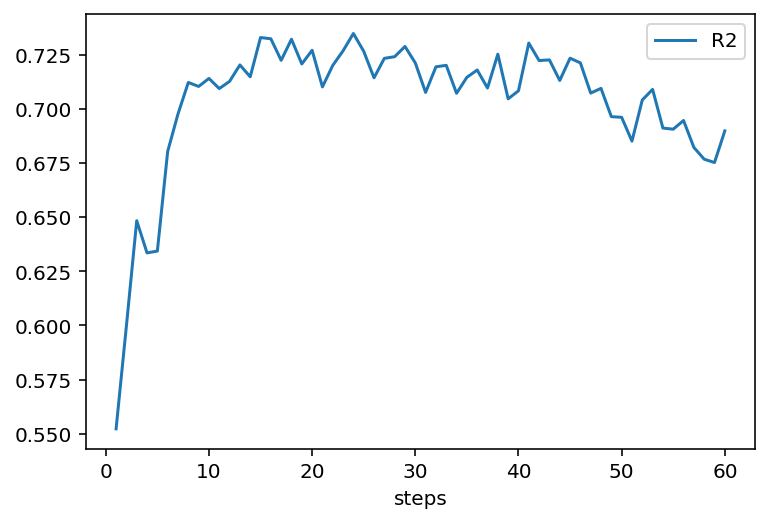

In [58]:
# 실험 결과 보기

df = pd.DataFrame(result, columns=['steps', 'R2']).set_index('steps')
df.plot()

In [59]:
# 최대 성능을 얻는 n_steps 찾기
df.idxmax(), df.max()

(R2    24
 dtype: int64,
 R2    0.734913
 dtype: float64)

# shift 이용법

## 다중변수 예측

- 자신의 과거값 뿐 아니라 다른 특성 값도 같이 사용하는 방법
- 과거의 전력사용량과 날씨를 추가로 입력으로 사용하는 경우
- 미래 3일간 전력사용량 예측

### shift()
- 어떤 특성(컬럼) 값의 과거 데이터를 같이 사용할 때 shift()를 이용한다

In [67]:
df = df_down.copy()

# 오늘과 하루 전의 데이터도 같이 사용하는 경우 (컬럼 추가하는 방법)
# 예를 들어 3일차를 예측하는데 1일과 2일 데이터를 사용한다

df['load-1'] = df.load.shift(1)
df[:5]

,load,temp,load-1
timestamp,,,
2012-01-01,71562.0,37.763889,NaN
2012-01-02,76841.0,37.402778,71562.0
2012-01-03,87887.0,17.430556,76841.0
2012-01-04,92168.0,13.111111,87887.0
2012-01-05,88096.0,24.875000,92168.0


- 과거 4일간의 전력사용 데이터 컬럼을 추가하는 방법

In [68]:
N_load = 4
for i in range (1,N_load + 1):
    df['load-'+str(i)]=df.load.shift(i)
df[:10]

,load,temp,load-1,load-2,load-3,load-4
timestamp,,,,,,
2012-01-01,71562.0,37.763889,NaN,NaN,NaN,NaN
2012-01-02,76841.0,37.402778,71562.0,NaN,NaN,NaN
2012-01-03,87887.0,17.430556,76841.0,71562.0,NaN,NaN
2012-01-04,92168.0,13.111111,87887.0,76841.0,71562.0,NaN
2012-01-05,88096.0,24.875000,92168.0,87887.0,76841.0,71562.0
2012-01-06,85591.0,25.902778,88096.0,92168.0,87887.0,76841.0
2012-01-07,76869.0,31.652778,85591.0,88096.0,92168.0,87887.0
2012-01-08,77767.0,30.000000,76869.0,85591.0,88096.0,92168.0
2012-01-09,85818.0,25.277778,77767.0,76869.0,85591.0,88096.0


-  과거 2일간의 날씨 데이터를 추가

In [69]:
N_temp = 2
for i in range (1,N_temp+1):
    df['temp-'+str(i)]=df.temp.shift(i)

In [65]:
df[:10]

,load,temp,load-1,load-2,load-3,load-4,temp-1,temp-2
timestamp,,,,,,,,
2012-01-01,71562.0,37.763889,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-02,76841.0,37.402778,71562.0,NaN,NaN,NaN,37.763889,NaN
2012-01-03,87887.0,17.430556,76841.0,71562.0,NaN,NaN,37.402778,37.763889
2012-01-04,92168.0,13.111111,87887.0,76841.0,71562.0,NaN,17.430556,37.402778
2012-01-05,88096.0,24.875000,92168.0,87887.0,76841.0,71562.0,13.111111,17.430556
2012-01-06,85591.0,25.902778,88096.0,92168.0,87887.0,76841.0,24.875000,13.111111
2012-01-07,76869.0,31.652778,85591.0,88096.0,92168.0,87887.0,25.902778,24.875000
2012-01-08,77767.0,30.000000,76869.0,85591.0,88096.0,92168.0,31.652778,25.902778
2012-01-09,85818.0,25.277778,77767.0,76869.0,85591.0,88096.0,30.000000,31.652778


- 목적변수 추가: 미래 3일까지 예측하는 경우
- 목적변수는 load의 다음 날 값이다 (y+1 은 하루 후를 예측하는 것)

In [70]:
N_target = 3
for i in range (1, N_target+1):
    df['y+'+str(i)]=df.load.shift(-i)

In [71]:
df[:10]

,load,temp,load-1,load-2,load-3,load-4,temp-1,temp-2,y+1,y+2,y+3
timestamp,,,,,,,,,,,
2012-01-01,71562.0,37.763889,NaN,NaN,NaN,NaN,NaN,NaN,76841.0,87887.0,92168.0
2012-01-02,76841.0,37.402778,71562.0,NaN,NaN,NaN,37.763889,NaN,87887.0,92168.0,88096.0
2012-01-03,87887.0,17.430556,76841.0,71562.0,NaN,NaN,37.402778,37.763889,92168.0,88096.0,85591.0
2012-01-04,92168.0,13.111111,87887.0,76841.0,71562.0,NaN,17.430556,37.402778,88096.0,85591.0,76869.0
2012-01-05,88096.0,24.875000,92168.0,87887.0,76841.0,71562.0,13.111111,17.430556,85591.0,76869.0,77767.0
2012-01-06,85591.0,25.902778,88096.0,92168.0,87887.0,76841.0,24.875000,13.111111,76869.0,77767.0,85818.0
2012-01-07,76869.0,31.652778,85591.0,88096.0,92168.0,87887.0,25.902778,24.875000,77767.0,85818.0,85158.0
2012-01-08,77767.0,30.000000,76869.0,85591.0,88096.0,92168.0,31.652778,25.902778,85818.0,85158.0,85021.0
2012-01-09,85818.0,25.277778,77767.0,76869.0,85591.0,88096.0,30.000000,31.652778,85158.0,85021.0,84824.0


In [72]:
df[-5:]

,load,temp,load-1,load-2,load-3,load-4,temp-1,temp-2,y+1,y+2,y+3
timestamp,,,,,,,,,,,
2014-12-27,73845.0,38.666667,74155.0,69507.0,77368.0,83002.0,41.569444,44.486111,74678.0,84486.0,88810.0
2014-12-28,74678.0,43.125000,73845.0,74155.0,69507.0,77368.0,38.666667,41.569444,84486.0,88810.0,89246.0
2014-12-29,84486.0,30.305556,74678.0,73845.0,74155.0,69507.0,43.125000,38.666667,88810.0,89246.0,NaN
2014-12-30,88810.0,18.347222,84486.0,74678.0,73845.0,74155.0,30.305556,43.125000,89246.0,NaN,NaN
2014-12-31,89246.0,17.375000,88810.0,84486.0,74678.0,73845.0,18.347222,30.305556,NaN,NaN,NaN


- 결측치 제거
- 원 데이터의 시작과 끝부분 일부 데이터가 학습에 사용되지 못한다 (샘플수가 적을 때 주의)

In [73]:
df = df.dropna()
print(df.shape)

(1089, 11)


In [78]:
df[:10]

,load,temp,load-1,load-2,load-3,load-4,load-5,load-6,load-7,load-8,...,load-21,load-22,load-23,load-24,load-25,load-26,load-27,load-28,load-29,load-30
timestamp,,,,,,,,,,,,,,,,,,,,,
2012-01-31,84069.0,26.236111,83643.0,75625.0,74928.0,81654.0,81906.0,81543.0,79804.0,84221.0,...,85158.0,85818.0,77767.0,76869.0,85591.0,88096.0,92168.0,87887.0,76841.0,71562.0
2012-02-01,81283.0,33.875000,84069.0,83643.0,75625.0,74928.0,81654.0,81906.0,81543.0,79804.0,...,85021.0,85158.0,85818.0,77767.0,76869.0,85591.0,88096.0,92168.0,87887.0,76841.0
2012-02-02,81645.0,29.319444,81283.0,84069.0,83643.0,75625.0,74928.0,81654.0,81906.0,81543.0,...,84824.0,85021.0,85158.0,85818.0,77767.0,76869.0,85591.0,88096.0,92168.0,87887.0
2012-02-03,82814.0,25.291667,81645.0,81283.0,84069.0,83643.0,75625.0,74928.0,81654.0,81906.0,...,83503.0,84824.0,85021.0,85158.0,85818.0,77767.0,76869.0,85591.0,88096.0,92168.0
2012-02-04,78043.0,26.055556,82814.0,81645.0,81283.0,84069.0,83643.0,75625.0,74928.0,81654.0,...,84300.0,83503.0,84824.0,85021.0,85158.0,85818.0,77767.0,76869.0,85591.0,88096.0
2012-02-05,78345.0,21.750000,78043.0,82814.0,81645.0,81283.0,84069.0,83643.0,75625.0,74928.0,...,88319.0,84300.0,83503.0,84824.0,85021.0,85158.0,85818.0,77767.0,76869.0,85591.0
2012-02-06,79866.0,35.513889,78345.0,78043.0,82814.0,81645.0,81283.0,84069.0,83643.0,75625.0,...,91228.0,88319.0,84300.0,83503.0,84824.0,85021.0,85158.0,85818.0,77767.0,76869.0
2012-02-07,80065.0,31.416667,79866.0,78345.0,78043.0,82814.0,81645.0,81283.0,84069.0,83643.0,...,83799.0,91228.0,88319.0,84300.0,83503.0,84824.0,85021.0,85158.0,85818.0,77767.0
2012-02-08,83039.0,24.305556,80065.0,79866.0,78345.0,78043.0,82814.0,81645.0,81283.0,84069.0,...,84192.0,83799.0,91228.0,88319.0,84300.0,83503.0,84824.0,85021.0,85158.0,85818.0


- 모든 특성을 사용하고 내일의 전력 사용량을 예측하는 경우

In [74]:
X = df[df.columns.difference(['y+1', 'y+2', 'y+3'])]
y = df['y+1']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                shuffle=False, random_state=9)

In [75]:
lin = LinearRegression()
lin.fit(X_train, y_train) 
lin.score(X_test, y_test).round(4) 

0.6491

## 과거 30일 데이터 사용
- 내일 전력사용량 예측 (y+1)

In [92]:
df = df_down.copy()

N_load = 30
for i in range (1,N_load + 1):
    df['load-'+str(i)]=df.load.shift(i)
    
# N_temp = 30
# for i in range (1,N_temp+1):
#     df['temp-'+str(i)]=df.temp.shift(i)
    
N_target = 3
for i in range (1, N_target+1):
    df['y+'+str(i)]=df.load.shift(-i)

In [93]:
df = df.dropna()
df.shape

(1063, 35)

In [94]:
df[:3]

,load,temp,load-1,load-2,load-3,load-4,load-5,load-6,load-7,load-8,...,load-24,load-25,load-26,load-27,load-28,load-29,load-30,y+1,y+2,y+3
timestamp,,,,,,,,,,,,,,,,,,,,,
2012-01-31,84069.0,26.236111,83643.0,75625.0,74928.0,81654.0,81906.0,81543.0,79804.0,84221.0,...,76869.0,85591.0,88096.0,92168.0,87887.0,76841.0,71562.0,81283.0,81645.0,82814.0
2012-02-01,81283.0,33.875000,84069.0,83643.0,75625.0,74928.0,81654.0,81906.0,81543.0,79804.0,...,77767.0,76869.0,85591.0,88096.0,92168.0,87887.0,76841.0,81645.0,82814.0,78043.0
2012-02-02,81645.0,29.319444,81283.0,84069.0,83643.0,75625.0,74928.0,81654.0,81906.0,81543.0,...,85818.0,77767.0,76869.0,85591.0,88096.0,92168.0,87887.0,82814.0,78043.0,78345.0


In [105]:
X = df[df.columns.difference(['y+1','y+2','y+3'])]
y = df['y+1']
# y = df['y+2']  # 2일 후 예측 
# y = df['y+3']  # 3일 후 예측 

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                shuffle=False, random_state=9)
lin.fit(X_train, y_train) 
lin.score(X_test, y_test).round(4)

0.7999

In [104]:
y_pred = lin.predict(X_test)
show_reg_result(y_test, y_pred)

Max Error:  13011.015
Mean Absolute Error:  3057.181
Root Mean Squared Error:  4028.544
R-Squared:  0.626


- 모델과 데이터를 주고 학습 수행후 성능을 평가하는 함수
- 디폴트로 shuffle=False 로 설정함 (시계열 데이터 이므로 과거 데이터로만 학습)

In [108]:
def model_run(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                shuffle=False, random_state=9)
    model.fit(X_train, y_train) 
    return model.score(X_test, y_test).round(4)

- 동작 확인

In [110]:
y = df['y+1']
model_run(lin, X, y)

0.7999

In [111]:
y = df['y+3']
model_run(lin, X, y)

0.561

### 선형, 랜덤포레스트, 부스팅 비교

In [117]:
rfr = RandomForestRegressor()
lgbm_r = LGBMRegressor(num_leaves=16)

res = []
for model in [lin, rfr, lgbm_r]:
    for i in range(1,4):
        y = df['y+'+str(i)]
        r2 = model_run(model, X, y)
        res.append((model, i, r2))
res

[(LinearRegression(), 1, 0.7999),
 (LinearRegression(), 2, 0.6262),
 (LinearRegression(), 3, 0.561),
 (RandomForestRegressor(), 1, 0.7389),
 (RandomForestRegressor(), 2, 0.6028),
 (RandomForestRegressor(), 3, 0.5515),
 (LGBMRegressor(num_leaves=16), 1, 0.7793),
 (LGBMRegressor(num_leaves=16), 2, 0.577),
 (LGBMRegressor(num_leaves=16), 3, 0.5215)]

### 랜덤 포레스트 다중 예측
- 랜덤 포레스트는 한번에 여러개의 y 값을 예측하는 모델을 지원한다
- 아래는 y에 3개의 값을 예측하도록 했다

In [118]:
y = df[['y+1', 'y+2', 'y+3']]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                        shuffle=False, random_state=9)
rfr.fit(X_train, y_train) 
y_pred = rfr.predict(X_test)
r2_score(y_test, y_pred, multioutput='raw_values')

array([0.71994816, 0.56718913, 0.51526831])

## 기타 특성 추가
- 이동평균, 이동분산, 최대-최소 차이, 평활화(ewma: Exponentially-weighted moving average) 등 특성을 추가할 수 있다

In [119]:
# 과거 5일간의 이동 평균치를 컬럼에 추가
X2= X.copy()
X2["5-mean"] = X2.load.rolling(5,min_periods=1).mean()
X2[:5]

,load,load-1,load-10,load-11,load-12,load-13,load-14,load-15,load-16,load-17,...,load-3,load-30,load-4,load-5,load-6,load-7,load-8,load-9,temp,5-mean
timestamp,,,,,,,,,,,,,,,,,,,,,
2012-01-31,84069.0,83643.0,85869.0,87129.0,90190.0,84192.0,83799.0,91228.0,88319.0,84300.0,...,74928.0,71562.0,81654.0,81906.0,81543.0,79804.0,84221.0,82897.0,26.236111,84069.000000
2012-02-01,81283.0,84069.0,82897.0,85869.0,87129.0,90190.0,84192.0,83799.0,91228.0,88319.0,...,75625.0,76841.0,74928.0,81654.0,81906.0,81543.0,79804.0,84221.0,33.875000,82676.000000
2012-02-02,81645.0,81283.0,84221.0,82897.0,85869.0,87129.0,90190.0,84192.0,83799.0,91228.0,...,83643.0,87887.0,75625.0,74928.0,81654.0,81906.0,81543.0,79804.0,29.319444,82332.333333
2012-02-03,82814.0,81645.0,79804.0,84221.0,82897.0,85869.0,87129.0,90190.0,84192.0,83799.0,...,84069.0,92168.0,83643.0,75625.0,74928.0,81654.0,81906.0,81543.0,25.291667,82452.750000
2012-02-04,78043.0,82814.0,81543.0,79804.0,84221.0,82897.0,85869.0,87129.0,90190.0,84192.0,...,81283.0,88096.0,84069.0,83643.0,75625.0,74928.0,81654.0,81906.0,26.055556,81570.800000


- 다양한 특성 추가 예시
- ema에 지수형 가중값을 구한다
- min_periods=1 의 의미는 필요한 갯수가 되지 않더라도, 한개라도 평균 등을 계산하라는 뜻임 (초기 값들을 버리지 않기 위함)

In [120]:
X2["20-mean"] = X2.load.rolling(20,min_periods=1).mean()
X2["10-std"] = X2.load.rolling(10, min_periods=1).std().fillna(0)
X2['5EWMA'] = X2.load.ewm(span=5).mean()
X2["5-max"] = X2.load.rolling(5, min_periods=1).max()
X2["5-min"] = X2.load.rolling(5, min_periods=1).min()
X2["5-peak-difference"] = X2.load.rolling(5, min_periods=1).max()-X2.load.rolling(5, min_periods=1).min()
X2[:3]

,load,load-1,load-10,load-11,load-12,load-13,load-14,load-15,load-16,load-17,...,load-8,load-9,temp,5-mean,20-mean,10-std,5EWMA,5-max,5-min,5-peak-difference
timestamp,,,,,,,,,,,,,,,,,,,,,
2012-01-31,84069.0,83643.0,85869.0,87129.0,90190.0,84192.0,83799.0,91228.0,88319.0,84300.0,...,84221.0,82897.0,26.236111,84069.000000,84069.000000,0.000000,84069.0,84069.0,84069.0,0.0
2012-02-01,81283.0,84069.0,82897.0,85869.0,87129.0,90190.0,84192.0,83799.0,91228.0,88319.0,...,79804.0,84221.0,33.875000,82676.000000,82676.000000,1969.999492,82397.4,84069.0,81283.0,2786.0
2012-02-02,81645.0,81283.0,84221.0,82897.0,85869.0,87129.0,90190.0,84192.0,83799.0,91228.0,...,81543.0,79804.0,29.319444,82332.333333,82332.333333,1514.849607,82041.0,84069.0,81283.0,2786.0


In [122]:
# X2를 사용하는 경우의 성능 비교 (아래에서 X2를 사용함)
res = []
for model in [lin, rfr, lgbm_r]:
    for i in range(1,4):
        y = df['y+'+str(i)]
        r2 = model_run(model, X2, y)
        res.append((model, i, r2))
res

[(LinearRegression(), 1, 0.7979),
 (LinearRegression(), 2, 0.6173),
 (LinearRegression(), 3, 0.5502),
 (RandomForestRegressor(), 1, 0.7395),
 (RandomForestRegressor(), 2, 0.5824),
 (RandomForestRegressor(), 3, 0.511),
 (LGBMRegressor(num_leaves=16), 1, 0.7668),
 (LGBMRegressor(num_leaves=16), 2, 0.5704),
 (LGBMRegressor(num_leaves=16), 3, 0.4774)]